# Baseline 
Pour une baseline naïve, nous pourrions deviner la même valeur pour tous les exemples de l'ensemble de test. On nous demande de prédire la probabilité de ne pas rembourser le prêt, donc si nous sommes totalement incertains, nous devinerions 0,5 pour toutes les observations de l'ensemble de test. Cela nous donnera une zone caractéristique de fonctionnement du récepteur sous la courbe (AUC ROC) de 0,5 dans la compétition ([une classification aléatoire obtiendra un 0,5](https://stats.stackexchange.com/questions/266387/can-auc-roc-be-between-0-0-5)).

Puisque nous savons déjà quel score nous allons obtenir, nous n’avons pas vraiment besoin de faire une estimation naïve. Utilisons un modèle légèrement plus sophistiqué pour notre référence actuelle : la régression logistique.
Nous commencerons par analyse quelles sont les paramètres les plus adaptés à notre régression logistique puis nous les appliquerons à notre modèle.

In [1]:
import pandas as pd
import numpy as np
import time
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

Pour analyser la pertinence du modèle que nous sélectionnerons, nous devons créer une fonction qui pénalise les mauvaises prédiction et plus particulièrement les False Negative. Ce sont des prédictions du modèle qui prédise un 0 alors que nous attendons un 1. Cette prédiction est plus dangereuse pour la pertinence du modèle car si nous prédisons un remboursement probable d'un crédit et que cela n'est pas le cas, cela impacte directement la rentabilité de la banque, ce qui n'est pas souhaitable.

In [2]:
def custom_penalty(y_true, y_pred):
    precision = accuracy_score(y_test, y_pred)
    penalty = 0.0
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 0:
            penalty = precision * 0.1
    return precision - penalty

penalty_scorer = make_scorer(custom_penalty, greater_is_better=False)

In [3]:
X_train = pd.read_csv('X_train_CSV.csv')
X_test = pd.read_csv('X_test_CSV.csv')
y_train = pd.read_csv('y_train_CSV.csv')
y_test = pd.read_csv('y_test_CSV.csv')

In [4]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
logistic_model = LogisticRegression(C= 1, penalty='l1', solver='liblinear')

In [6]:
scores = cross_val_score(logistic_model, X_train_scaled, y_train, cv=5,\
                         scoring='neg_mean_squared_error')
print("Scores de validation croisée:", scores)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Scores de validation croisée: [-0.0047619  -0.00147392 -0.00204082 -0.00136054 -0.0015873 ]


Nous affichons le temps de traitement de notre modèle qui nous serviras de metric pour sélectionner le plus performant.

In [7]:
start_time = time.time()
logistic_model.fit(X_train_scaled, y_train)
end_time = time.time()
execution_time = end_time - start_time
print(f"Le temps de traitement est de : {execution_time} secondes")

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Le temps de traitement est de : 17.55416488647461 secondes


In [8]:
test_score = logistic_model.score(X_test, y_test)
test_score

X has feature names, but LogisticRegression was fitted without feature names


0.4148376564483947

In [9]:
y_pred = logistic_model.predict(X_test_scaled)

In [10]:
accuracy_score(y_test, y_pred)

0.9987302738980591

Nous affichons la précisions du modèle avec une pénalité si notre modèle crée des False Negative

In [11]:
custom_penalty(y_test, y_pred)

0.9987302738980591

In [12]:
from sklearn import metrics
print("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE : 0.04


In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
auc_score

0.9986923379699972

In [14]:
explainer = shap.Explainer(logistic_model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


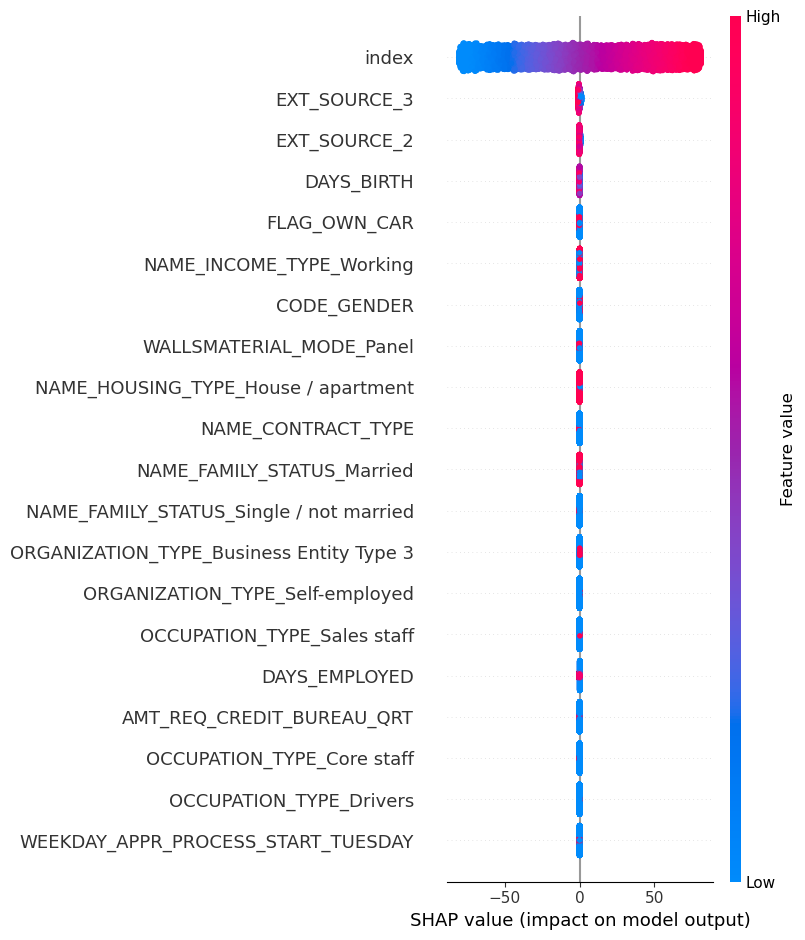

In [15]:
feature_names = X_test.columns.tolist()
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)

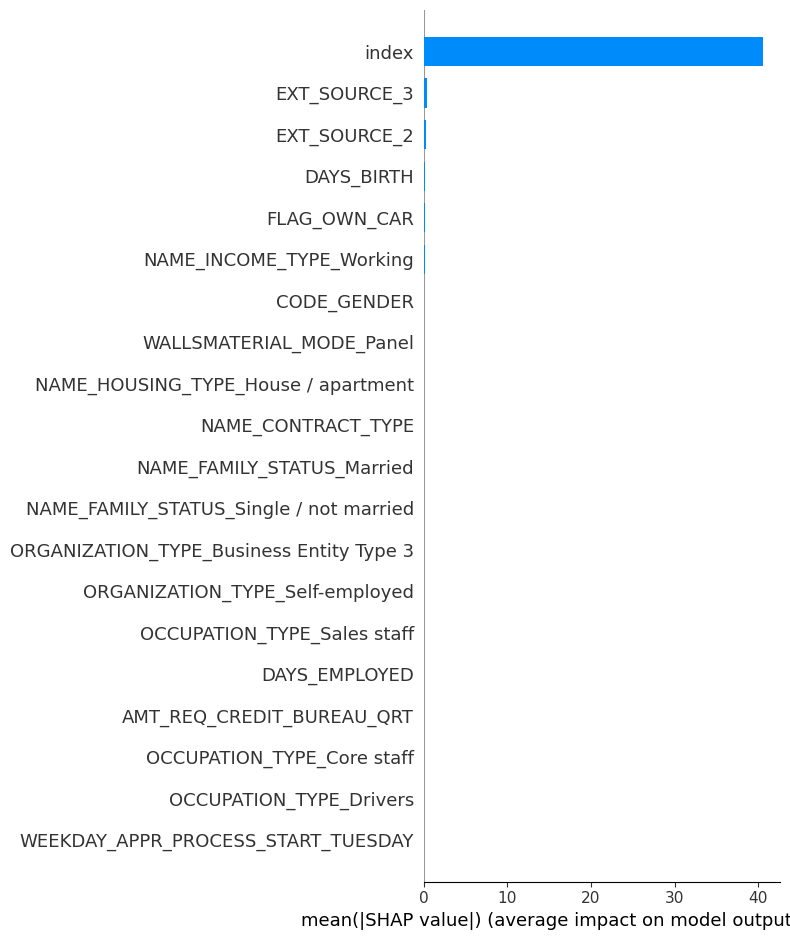

In [16]:
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", feature_names=feature_names)